# random forest model

features:
- BlockDensity
- OtherPuzAns
- AnswerLength

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
features = pd.read_csv('nick_df_features.csv',index_col=0)

features.sample(5)

,Date,Weekday,BlockDensity,OtherPuzAns,AnswerLength,WeekdayNum
9273,2019-09-03,Tuesday,14.222222,6907,5.078947,1
7680,2015-04-22,Wednesday,16.444444,3771,4.947368,2
6917,2013-03-19,Tuesday,15.111111,4900,4.897436,1
9031,2019-01-03,Thursday,17.333333,4232,5.470588,3
227,1994-08-17,Wednesday,16.888889,6418,5.054054,2


In [3]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

In [4]:
X = features[['BlockDensity','OtherPuzAns','AnswerLength']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

## cross-validation for max depth

In [6]:
# n will be the maximum max_depth I consider
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
n = 20

accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

for j in range(1,n+1):
    print("iteration ",j)
    rf = RandomForestClassifier(n_estimators = 500, max_depth=j, random_state=617)
    i=0
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train,y_train_train.ravel())
        
        y_predict = rf_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs[i,j-1] = precision_score(y_train_test,y_predict,average='weighted',zero_division=0)
        recs[i,j-1] = recall_score(y_train_test,y_predict,average='weighted',zero_division=0)
        i = i + 1

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20


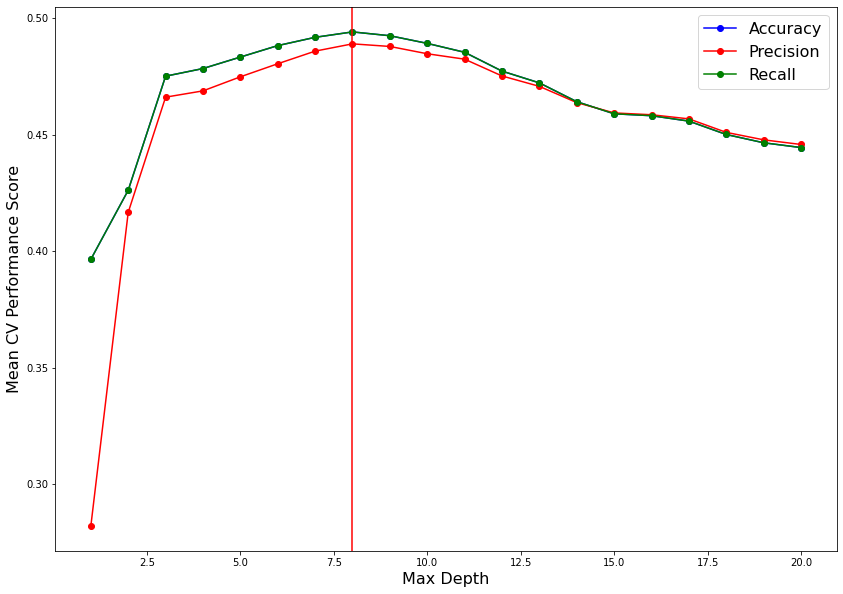

In [7]:
best_depth = np.argmax(np.mean(accs, axis=0))+1
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_depth, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [8]:
print(f"The highest accuraccy is in the model with a max depth of {best_depth}.")

The highest accuraccy is in the model with a max depth of 8.


## details on best model

In [9]:
rf_f = RandomForestClassifier(max_depth=best_depth, random_state=617)
rf_f.fit(X_train_train,y_train_train.ravel())

RandomForestClassifier(max_depth=8, random_state=617)

In [10]:
y_pred = rf_f.predict(X_test)
f_acc = accuracy_score(y_test,y_pred)
f_prec = precision_score(y_test,y_pred,average='micro')
f_rec = recall_score(y_test,y_pred,average='micro')
print(f"Overall scores:")
print(f"Accuracy:\t{np.round(f_acc*100,2)}%")
print(f"Precision:\t{np.round(f_prec*100,2)}%")
print(f"Recall:\t\t{np.round(f_rec*100,2)}%")

Overall scores:
Accuracy:	48.93%
Precision:	48.93%
Recall:		48.93%


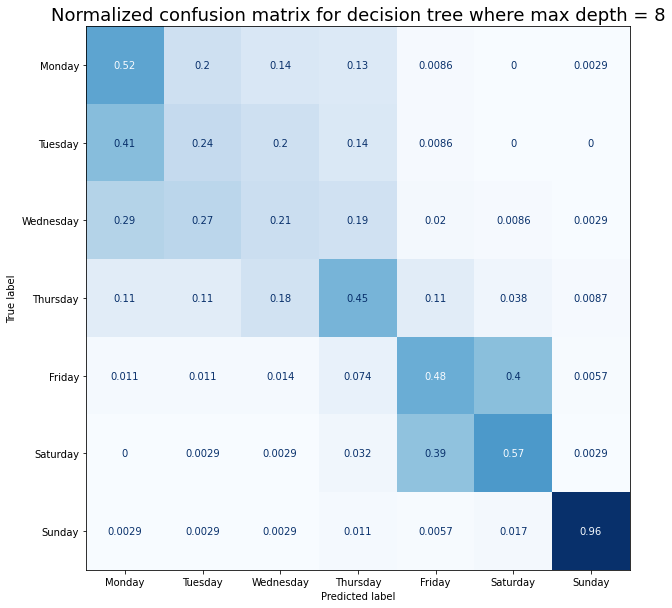

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(rf_f, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"Normalized confusion matrix for decision tree where max depth = {best_depth}", fontsize=18)
plt.show()